# Проект: классификация

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import optuna
from  sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing  import LabelEncoder, MinMaxScaler
from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics
from sklearn import preprocessing 
from sklearn.ensemble import GradientBoostingClassifier, StackingRegressor
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.feature_selection import SelectKBest, f_classif

## 1. Знакомство с данными, обработка пропусков и выбросов

In [2]:
df = pd.read_csv('data/bank_fin.csv', sep = ';')

### Задание 1

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11137 non-null  object
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(6), object(11)
memory usage: 1.4+ MB


In [4]:
# исследуем данные на предмет пропусков
# ваш код
df.isnull().sum()

age           0
job           0
marital       0
education     0
default       0
balance      25
housing       0
loan          0
contact       0
day           0
month         0
duration      0
campaign      0
pdays         0
previous      0
poutcome      0
deposit       0
dtype: int64

### Задание 2

In [5]:
# Узнаем есть ли в признаке job пропущенные значения

df['job'].value_counts()

management       2566
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
unknown            70
Name: job, dtype: int64

### Задание 3

In [6]:
df['balance'] = df['balance'].replace('unknown', np.nan)
df['balance'] = df['balance'].str.replace('\$', '')
df['balance'] = df['balance'].str.replace(',00', '')
df['balance'] = df['balance'].str.replace(' ', '')

df['balance'] = df['balance'].astype(float)
print(round(df['balance'].mean(),3))


1529.129


In [7]:
# альтернативный вариант с функцией
# def make_convert(row):
  #  row = str(row)
  #  if row != 'unknown':
  #      row = row.replace(',00', '')
  #      row = row.replace('$', '')
  #      row = row.replace(' ', '')
  #      return float(row)
 #   else:
 #       return np.nan

#df['balance'] = df['balance'].apply(make_convert)

### Задание 4

In [8]:
# обработаем пропуски в признаки balance , заменив их на медианные значения по данному признаку
df['balance'] = df['balance'].fillna(df['balance'].median())

In [9]:
print(round(df['balance'].mean(),3))

1526.936


### Задание 5

In [10]:

# обработаем пропуски в категориальных признаках: job и education, заменив их на модальные значения

df['job'] = df['job'].fillna(df['job'].mode()[0])
df['education'] = df['education'].fillna(df['education'].mode()[0])

popular_job = df['job'].mode()[0]

popular_education = df['education'].mode()[0]

selected_clients = df[(df['job'] == popular_job) & (df['education'] == popular_education)]

mean_balance = selected_clients['balance'].mean()
mean_balance_rounded = round(mean_balance, 3)

# Вывод результата
print(mean_balance_rounded)

1353.613


In [11]:
m_job = df['job'].mode()[0]
m_edu = df['education'].mode()[0]

df['job'] = df['job'].apply(lambda x: m_job if x == 'unknown' else x)
df['education'] = df['education'].apply(lambda x: m_edu if x == 'unknown' else x)
df_new = df[(df['job'] == 'management') & (df['education'] == 'secondary')]
round(df_new['balance'].mean(),3)

1598.883

### Задание 6

In [12]:
df['balance'].shape[0]

11162

In [13]:
# удалим все выбросы для признака balance

def outliers_iqr(data, feature):
    x = data[feature]
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 1.5)
    upper_bound = quartile_3 + (iqr * 1.5)
    outliers = data[(x < lower_bound) | (x > upper_bound)]
    cleaned = data[(x >= lower_bound) & (x <= upper_bound)]
    return outliers, cleaned, lower_bound, upper_bound

outliers, cleaned, lower_bound, upper_bound = outliers_iqr(df, 'balance')
print(f'Число выбросов по методу Тьюки: {outliers.shape[0]}')
print(f'Результирующее число записей: {cleaned.shape[0]}')
print(lower_bound)
print(upper_bound)


Число выбросов по методу Тьюки: 1057
Результирующее число записей: 10105
-2241.0
4063.0


In [14]:
df = cleaned

In [15]:
df['balance'].shape[0]

10105

## Часть 2:  Разведывательный анализ

### Задание 1

In [16]:
# Узнаем сколько клиентов открыли депозит
df['deposit'].value_counts()

no     5424
yes    4681
Name: deposit, dtype: int64

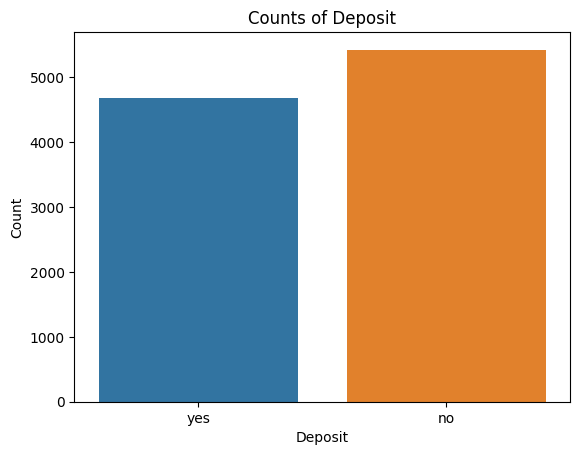

In [17]:
# Построение столбчатой диаграммы
sns.countplot(x='deposit', data=df)

# Настройка осей и названия диаграммы
plt.xlabel('Deposit')
plt.ylabel('Count')
plt.title('Counts of Deposit')

# Отображение диаграммы
plt.show()

### Задания 2 и 3

In [18]:
#рассчитаем описательные статистики для количественных переменных, проинтерпретируем результат
describe_features =['age','balance', 'day', 'campaign', 'pdays', 'duration', 'previous']

df[describe_features].describe()

,age,balance,day,campaign,pdays,duration,previous
count,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000
mean,40.895497,807.653538,15.590302,2.517170,51.319644,368.742603,0.816230
std,11.734931,994.151966,8.441510,2.707159,109.644179,346.651524,2.243795
min,18.000000,-2049.000000,1.000000,1.000000,-1.000000,2.000000,0.000000
25%,32.000000,95.000000,8.000000,1.000000,-1.000000,137.000000,0.000000
50%,38.000000,445.000000,15.000000,2.000000,-1.000000,252.000000,0.000000
75%,48.000000,1227.000000,22.000000,3.000000,2.000000,490.000000,1.000000
max,95.000000,4063.000000,31.000000,43.000000,854.000000,3881.000000,58.000000


In [19]:
# Создание графика
fig = px.histogram(df[describe_features], x='age', nbins=10)

# Настройка осей и заголовка
fig.update_layout(
    xaxis_title='Возраст',
    yaxis_title='Частота',
    title='Распределение возраста клиентов'
)

# Отображение графика
fig.show()

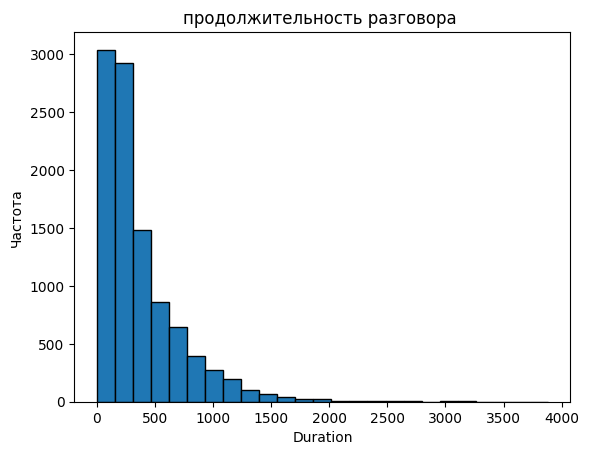

In [20]:
# Построение графика распределения продолжительности разговоров
plt.hist(df['duration'], bins=25, edgecolor='black')
plt.title("продолжительность разговора ")
plt.xlabel("Duration")
plt.ylabel("Частота")

plt.show()

### Задания 4 и 5

In [21]:
#рассчитаем описательные статистики для категориальных переменных, проинтерпретируем результат

df.describe(include='object')



,job,marital,education,default,housing,loan,contact,month,poutcome,deposit
count,10105,10105,10105,10105,10105,10105,10105,10105,10105,10105
unique,11,3,3,2,2,2,3,12,4,2
top,management,married,secondary,no,no,no,cellular,may,unknown,no
freq,2315,5715,5517,9939,5243,8712,7283,2617,7570,5424


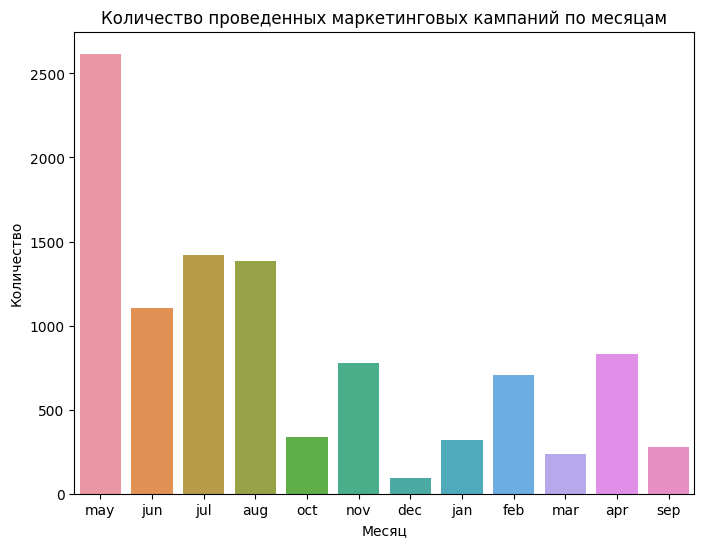

In [22]:
plt.figure(figsize=(8, 6))
sns.countplot(x='month', data=df)
plt.xlabel('Месяц')
plt.ylabel('Количество')
plt.title('Количество проведенных маркетинговых кампаний по месяцам')
plt.show()

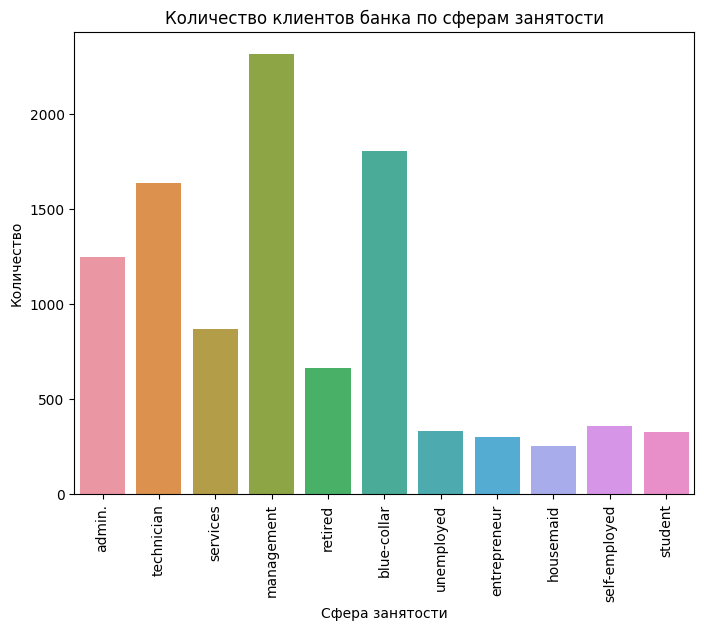

In [23]:
plt.figure(figsize=(8, 6))
sns.countplot(x='job', data=df)
plt.xlabel('Сфера занятости')
plt.ylabel('Количество')
plt.title('Количество клиентов банка по сферам занятости')
plt.xticks(rotation=90)
plt.show()

### Задание 6

<AxesSubplot: xlabel='poutcome'>

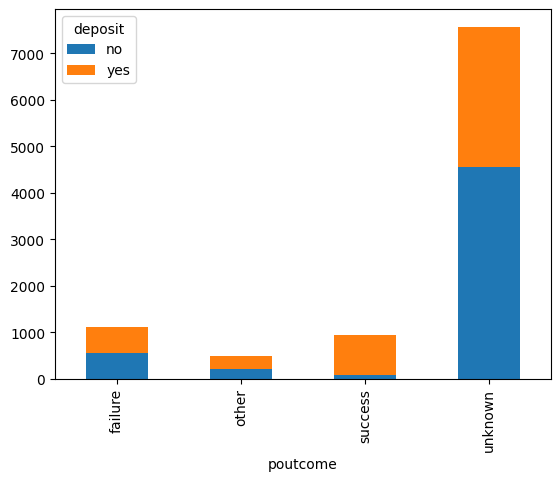

In [24]:
# Группировка данных по признаку poutcome и подсчет значений
status = df.groupby('poutcome')['deposit'].value_counts(normalize=False).unstack()
status.plot(kind='bar', stacked='True')



### Задание 7

In [25]:
# узнаем, в каком месяце чаще всего отказывались от предложения открыть депозит
month_failure = df.groupby(['poutcome'])['deposit', 'month'].value_counts(normalize=False).unstack()
month_failure

month               apr    aug   dec    feb    jan    jul    jun    mar  \
poutcome deposit                                                          
failure  no        84.0   19.0   2.0   71.0   30.0    8.0   10.0    1.0   
         yes       66.0   65.0   9.0   56.0    9.0   34.0   38.0   25.0   
other    no        32.0   10.0   3.0   36.0   26.0    3.0    3.0    5.0   
         yes       32.0   26.0   9.0   19.0   10.0   23.0   25.0   15.0   
success  no         6.0   13.0   NaN   10.0    3.0    4.0   11.0    1.0   
         yes       71.0  124.0  28.0   83.0   34.0   60.0   73.0   41.0   
unknown  no       195.0  733.0   4.0  206.0  135.0  821.0  582.0   17.0   
         yes      344.0  395.0  38.0  228.0   72.0  465.0  362.0  132.0   

month                may    nov    oct   sep  
poutcome deposit                              
failure  no        217.0   92.0   18.0  10.0  
         yes       118.0   47.0   44.0  36.0  
other    no         66.0   22.0    3.0   7.0  
         yes        47.0   18.0   17.0  24.0  
success  no         13.0   14.0    6.0   3.0  
         yes       104.0   71.0   84.0  88.0  
unknown  no       1480.0  328.0   35.0  26.0  
         yes       572.0  188.0  128.0  84.0

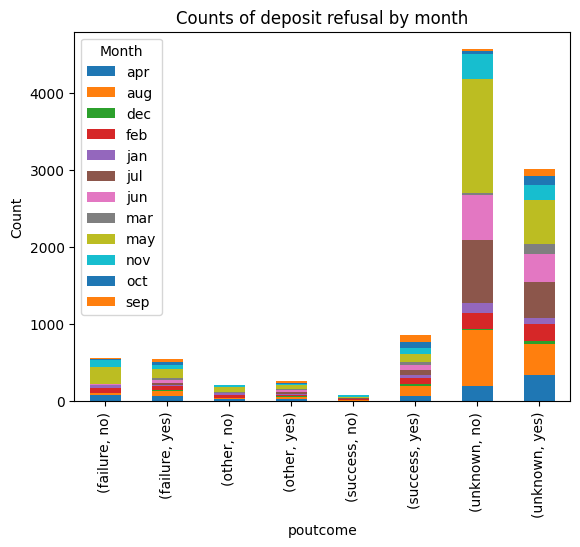

In [26]:
# Построение графика
month_failure.plot(kind='bar', stacked=True)
plt.xlabel('poutcome')
plt.ylabel('Count')
plt.title('Counts of deposit refusal by month')
plt.legend(title='Month')
plt.show()





In [27]:
# возможный вариант 
#for i in np.unique(df.month):
  #  print(i, df[(df.month == i)&(df.deposit == 'no')].shape[0]/df[(df.month == i)].shape[0])

### Задание 8

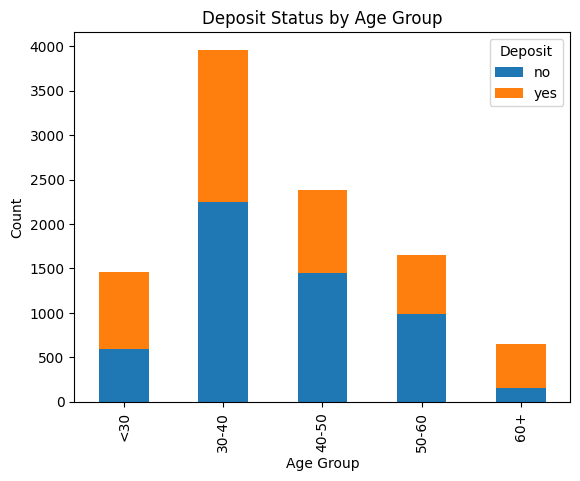

In [28]:
# создадим возрастные группы и определим, в каких группах более склонны открывать депозит

bins = [0, 30, 40, 50, 60, float('inf')]
labels = ['<30', '30-40', '40-50', '50-60', '60+']
df['AgeGroup'] = pd.cut(df['age'], bins=bins, labels=labels, right=False)

# Группировка данных по возрастным категориям и подсчет количества открытых и не открытых депозитов
grouped = df.groupby('AgeGroup')['deposit'].value_counts().unstack().fillna(0)

# Визуализация различий в количестве открытых/не открытых депозитов для каждой возрастной группы
grouped.plot(kind='bar', stacked=True)
plt.xlabel('Age Group')
plt.ylabel('Count')
plt.title('Deposit Status by Age Group')
plt.legend(title='Deposit', loc='upper right')
plt.show()


### Задания 9 и 10

In [29]:
# Функция для построения столбчатой диаграммы
def plot_bar_chart(data, xlabel, ylabel, title):
    fig, ax = plt.subplots()
    data.plot(kind='bar', ax=ax)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.legend(title='Deposit', loc='upper right')
    plt.xticks(rotation=45)
    plt.show()

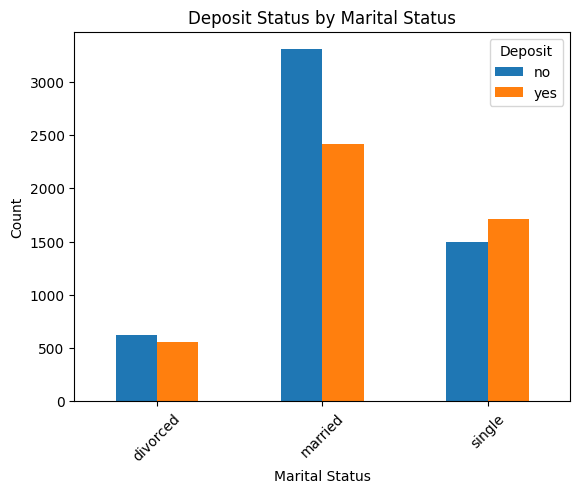

In [30]:
# построим визуализации для открывших и неоткрывших депозит в зависимости от семейного статуса

# Визуализация для семейного положения
family_status_counts = df.groupby('marital')['deposit'].value_counts().unstack()
plot_bar_chart(family_status_counts, 'Marital Status', 'Count', 'Deposit Status by Marital Status')

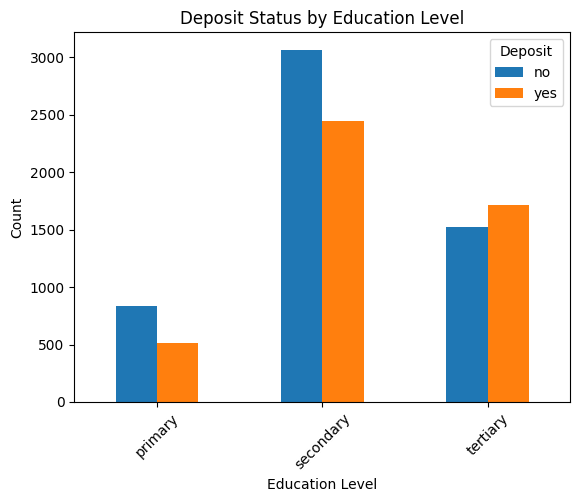

In [31]:
# построим визуализации для открывших и неоткрывших депозит в зависимости от образования

# Визуализация для уровня образования
education_counts = df.groupby('education')['deposit'].value_counts().unstack()
plot_bar_chart(education_counts, 'Education Level', 'Count', 'Deposit Status by Education Level')

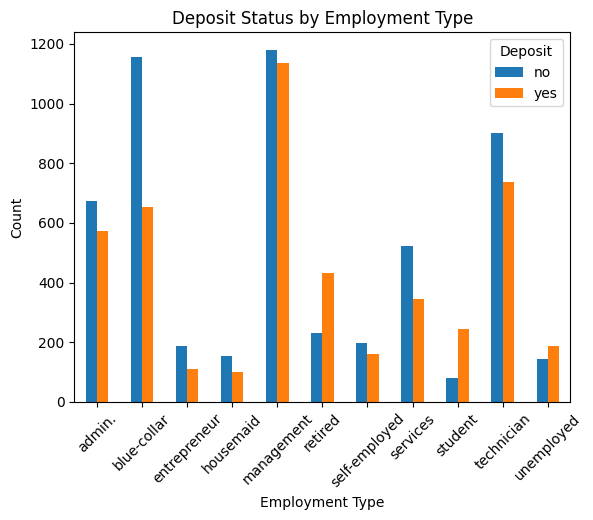

In [32]:
# построим визуализации для открывших и неоткрывших депозит в зависимости от вида профессиональной занятости
# Визуализация для сферы занятости
employment_counts = df.groupby('job')['deposit'].value_counts().unstack()
plot_bar_chart(employment_counts, 'Employment Type', 'Count', 'Deposit Status by Employment Type')

### Задание 11

In [33]:
# построим сводную таблицу, чтобы определить люди с каким образованием и семейным статусом наиболее многочисленны
#(если рассматривать тех, кто открыл депозит)

# Разделение таблицы на две части: открытые депозиты и неоткрытые депозиты
opened_deposits = df[df['deposit'] == 'yes']
not_opened_deposits = df[df['deposit'] == 'no']

# Создание сводных таблиц для каждой части 
opened_pivot = opened_deposits.pivot_table(index='education', columns='marital', aggfunc='size', fill_value=0)
not_opened_pivot = not_opened_deposits.pivot_table(index='education', columns='marital', aggfunc='size', fill_value=0)

print(opened_pivot)
print(not_opened_pivot)


marital    divorced  married  single
education                           
primary          96      339      82
secondary       283     1289     879
tertiary        174      784     755
marital    divorced  married  single
education                           
primary          91      641     100
secondary       370     1830     866
tertiary        163      832     531


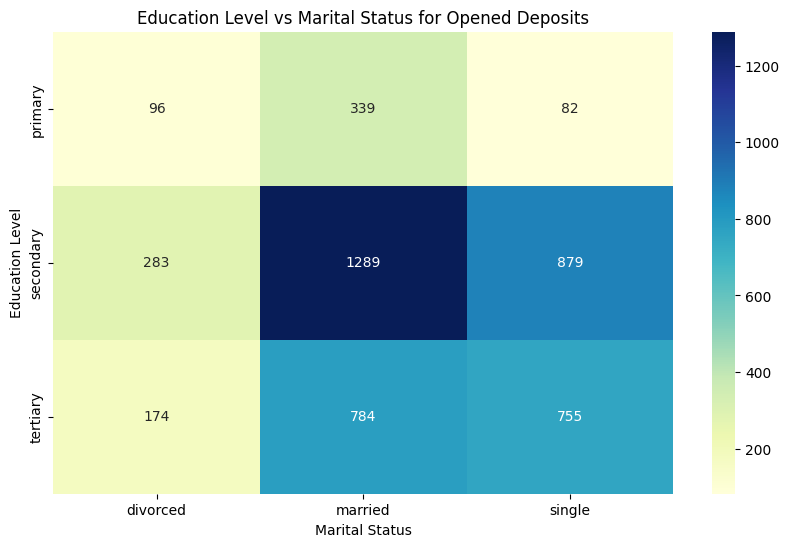

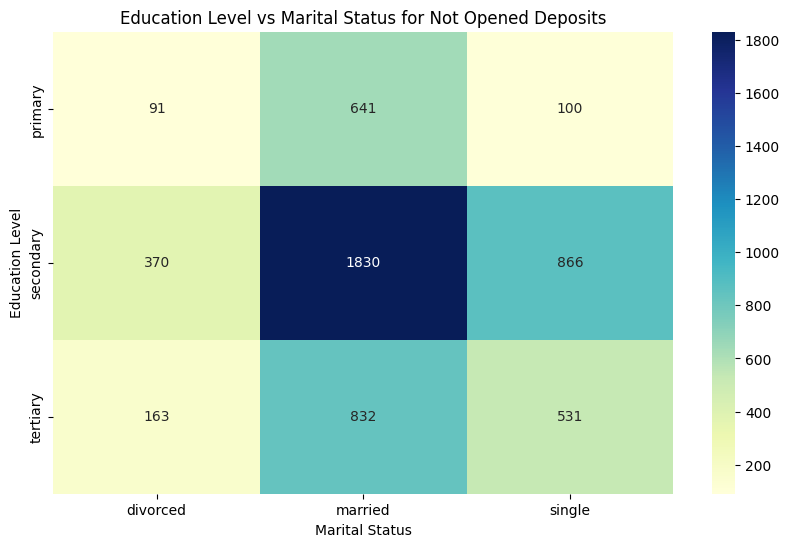

In [34]:
# Построение тепловых карт для открытых депозитов
plt.figure(figsize=(10, 6))
sns.heatmap(opened_pivot, annot=True, fmt='.0f', cmap='YlGnBu')
plt.xlabel('Marital Status')
plt.ylabel('Education Level')
plt.title('Education Level vs Marital Status for Opened Deposits')
plt.show()

# Построение тепловых карт для неоткрытых депозитов
plt.figure(figsize=(10, 6))
sns.heatmap(not_opened_pivot, annot=True, fmt='.0f', cmap='YlGnBu')
plt.xlabel('Marital Status')
plt.ylabel('Education Level')
plt.title('Education Level vs Marital Status for Not Opened Deposits')
plt.show()

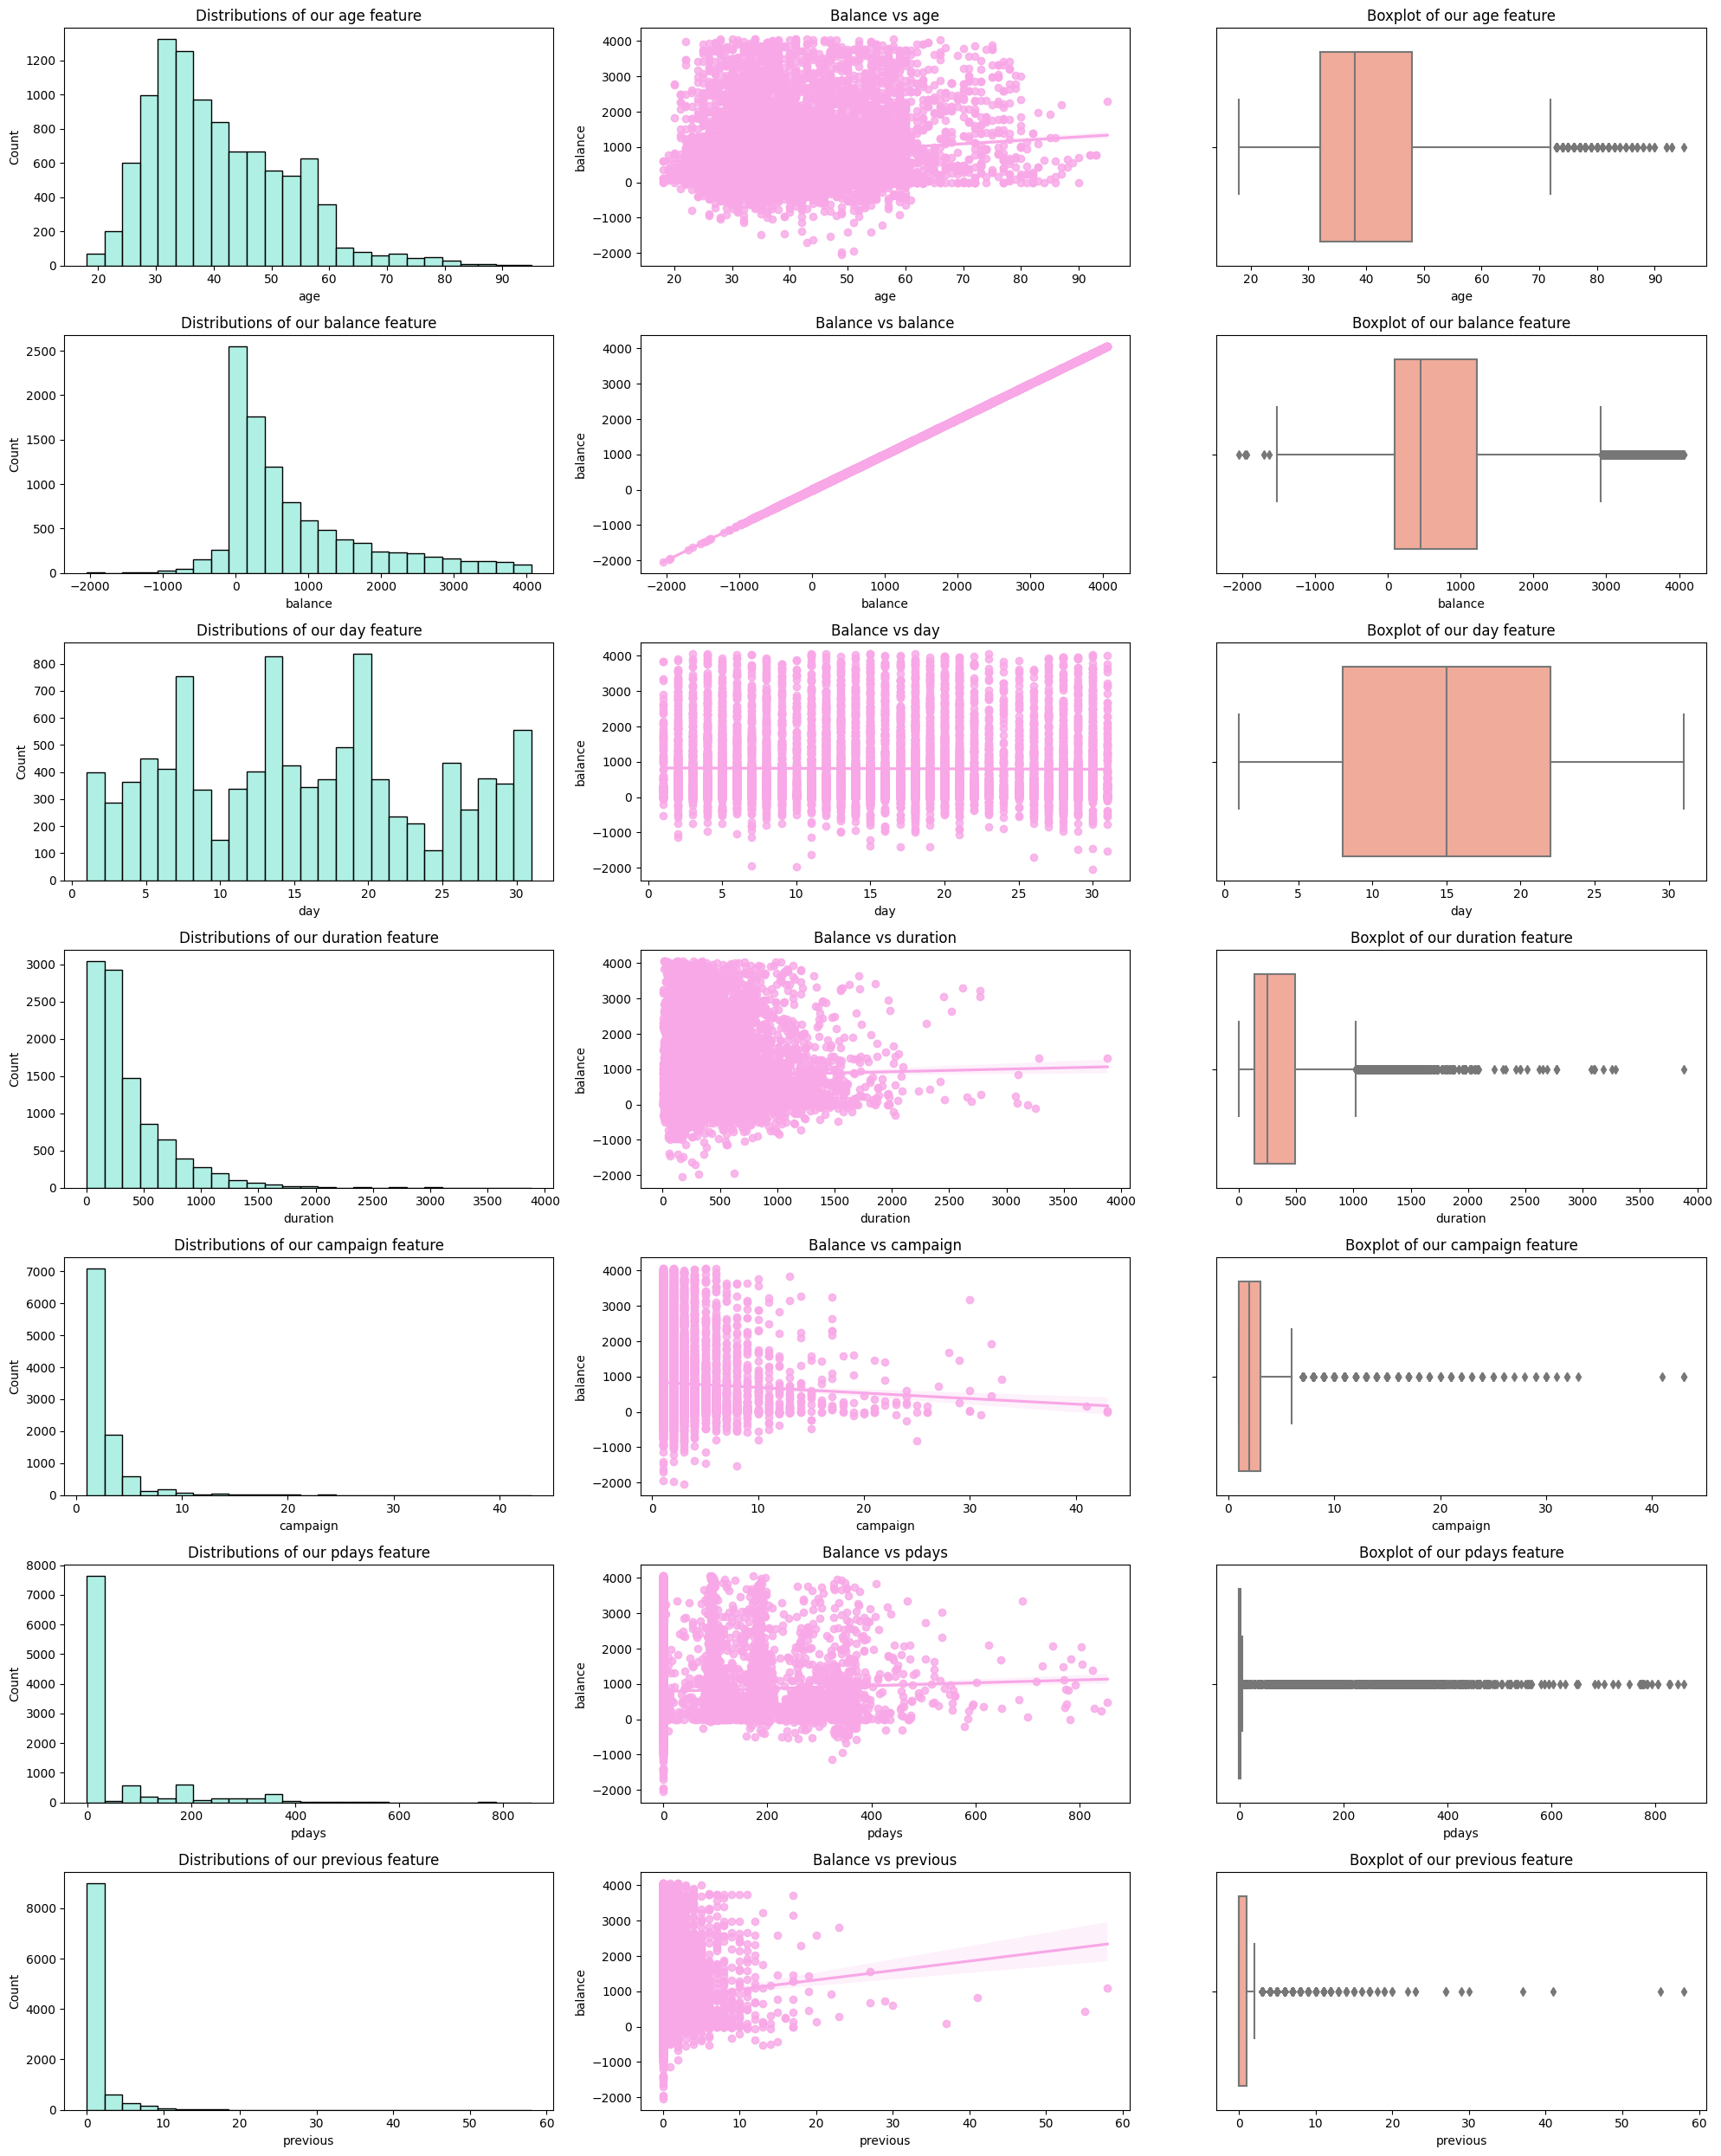

In [35]:
#рассчитаем описательные статистики для количественных переменных, проинтерпретируем результат
number_list = list(df.select_dtypes(include='number').columns)
n = len(number_list)
fig2, axes2 = plt.subplots(n, 3, figsize = (20,25))
for n, feature in enumerate(number_list):
    histogram = sns.histplot(data = df, x= feature, bins = 25, color= '#96ebdc', ax= axes2[n][0])
    histogram.set_title(f'Distributions of our {feature} feature')
    regplot = sns.regplot(data = df, x= feature, y = 'balance', color= '#f8a7e7',ax= axes2[n][1])
    regplot.set_title(f'Balance vs {feature}')
    boxplot = sns.boxplot(data = df, x= feature, orient = 'h', color= '#ffa28d',ax= axes2[n][2])
    boxplot.set_title(f'Boxplot of our {feature} feature')
plt.tight_layout()

## Часть 3: преобразование данных

### Задание 1

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10105 entries, 0 to 11161
Data columns (total 18 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   age        10105 non-null  int64   
 1   job        10105 non-null  object  
 2   marital    10105 non-null  object  
 3   education  10105 non-null  object  
 4   default    10105 non-null  object  
 5   balance    10105 non-null  float64 
 6   housing    10105 non-null  object  
 7   loan       10105 non-null  object  
 8   contact    10105 non-null  object  
 9   day        10105 non-null  int64   
 10  month      10105 non-null  object  
 11  duration   10105 non-null  int64   
 12  campaign   10105 non-null  int64   
 13  pdays      10105 non-null  int64   
 14  previous   10105 non-null  int64   
 15  poutcome   10105 non-null  object  
 16  deposit    10105 non-null  object  
 17  AgeGroup   10105 non-null  category
dtypes: category(1), float64(1), int64(6), object(10)
memory usage: 1.4

In [37]:


# Создание объекта LabelEncoder
encoder = LabelEncoder()

# Применение LabelEncoder к признаку "education"
df['education'] = encoder.fit_transform(df['education'])
print(df['education'].sum())
# Применение LabelEncoder к признаку "AgeGroup"
df['AgeGroup'] = encoder.fit_transform(df['AgeGroup'])
print(df.describe(include='object'))

11995
               job  marital default housing   loan   contact  month poutcome  \
count        10105    10105   10105   10105  10105     10105  10105    10105   
unique          11        3       2       2      2         3     12        4   
top     management  married      no      no     no  cellular    may  unknown   
freq          2315     5715    9939    5243   8712      7283   2617     7570   

       deposit  
count    10105  
unique       2  
top         no  
freq      5424  


внёс изменения вместо deposit_BIN оставил просто deposit

In [38]:
# модифицируем бинарные переменные 
df['default_BIN'] = df['default'].apply(lambda x: 1 if x=='yes' else 0)
df['housing_BIN'] = df['housing'].apply(lambda x: 1 if x=='yes' else 0)
df['loan_BIN'] = df['loan'].apply(lambda x: 1 if x=='yes' else 0)
df['deposit'] = df['deposit'].apply(lambda x: 1 if x=='yes' else 0)


In [39]:
# вычисляем стандартное отклонение
round(df.std(),3)

age             11.735
education        0.647
balance        994.152
day              8.442
duration       346.652
campaign         2.707
pdays          109.644
previous         2.244
deposit          0.499
AgeGroup         1.414
default_BIN      0.127
housing_BIN      0.500
loan_BIN         0.345
dtype: float64

In [40]:
# Вычисление среднего арифметического для 3 признаков 
mean_default = df['default_BIN'].mean()
mean_hausing = df['housing_BIN'].mean()
mean_loan = df['loan_BIN'].mean()

# Суммирование результатов
total_mean = mean_default + mean_hausing + mean_loan

# Округление до трех знаков после точки-разделителя
total_mean = round(total_mean, 3)

# Вывод результата
print(total_mean)

0.635


In [41]:

# создадим дамми-переменные
df =pd.get_dummies(df)
df.shape

(10105, 52)

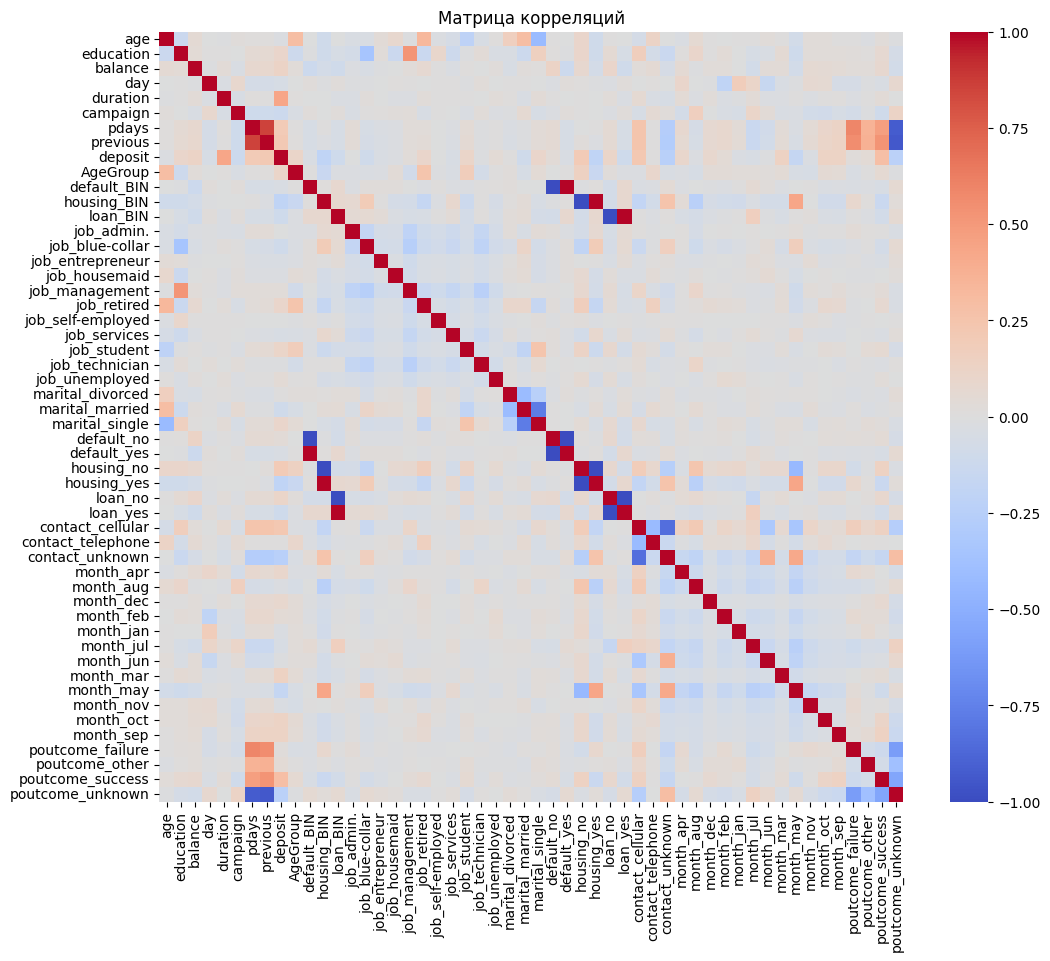

In [42]:
# построим корреляционную матрицу и оценим данные на предмет наличия мультиколлинеарности

# Вычисление матрицы корреляций
correlation_matrix = df.corr(method='kendall')

# Построение тепловой карты корреляционной матрицы
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm')
plt.title('Матрица корреляций')
plt.show()


<AxesSubplot: >

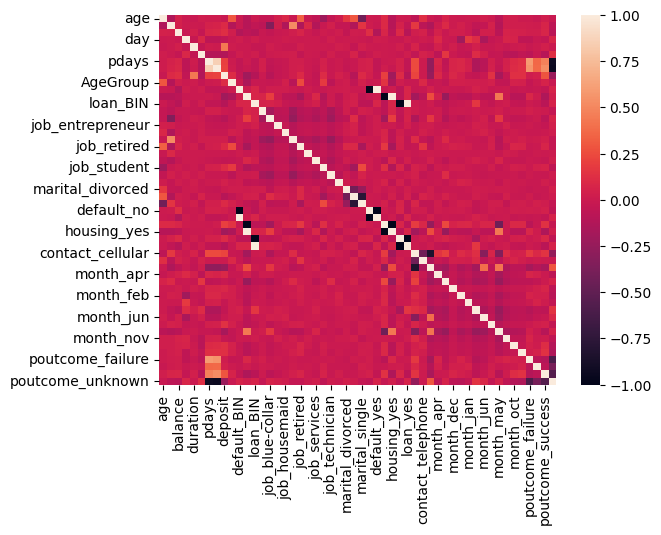

In [43]:
# отсеиваем числовые признаки и включаем отображение коэффициентов
sns.heatmap(df.corr(method='kendall', numeric_only=True))

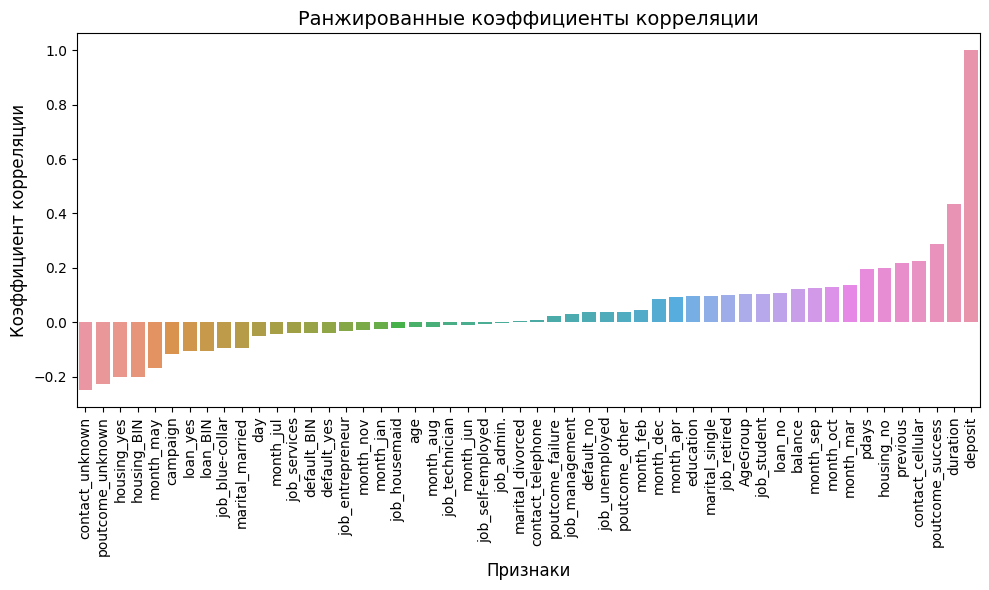

In [44]:

# ранжированные коэффициенты корреляции
# Сортируем коэффициенты корреляции по возрастанию
sorted_correlation = correlation_matrix['deposit'].sort_values()

# Создание нового графика с большим размером
plt.figure(figsize=(10, 6))

# Построение столбчатой диаграммы с использованием Seaborn
sns.barplot(x=sorted_correlation.index, y=sorted_correlation)
plt.xticks(rotation=90, fontsize=10)  # Поворот меток по оси x и изменение размера шрифта
plt.xlabel('Признаки', fontsize=12)
plt.ylabel('Коэффициент корреляции', fontsize=12)
plt.title('Ранжированные коэффициенты корреляции', fontsize=14)

# Увеличение отступов между столбцами для избежания слияния названий
plt.tight_layout()

plt.show()



In [45]:
# Задание порогового значения корреляции для определения мультиколлинеарности
threshold = 0.9

# Создание пустого списка для хранения пар признаков с сильной корреляцией
multicollinear_features = []

# Перебор всех признаков и их корреляций
for feature in correlation_matrix:
    correlated = correlation_matrix[feature][(correlation_matrix[feature] > threshold) & (correlation_matrix[feature] < 1.0)]
    if not correlated.empty:
        multicollinear_features.append((feature, correlated))
        
# Вывод пар признаков с сильной корреляцией (мультиколлинеарностью)
if multicollinear_features:
    print("Найдена мультиколлинеарность среди следующих признаков:")
    for feature, correlated in multicollinear_features:
        print(f"Признак: {feature}")
        print(f"Сильная корреляция с:")
        print(correlated)
        print("----------------------------------------")
else:
    print("Мультиколлинеарность не обнаружена.")

Найдена мультиколлинеарность среди следующих признаков:
Признак: loan_BIN
Сильная корреляция с:
loan_yes    1.0
Name: loan_BIN, dtype: float64
----------------------------------------
Признак: loan_yes
Сильная корреляция с:
loan_BIN    1.0
Name: loan_yes, dtype: float64
----------------------------------------


### Задания 7 и 8

In [46]:

X = df.drop(['deposit'], axis=1)
y = df['deposit']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)

In [47]:

# Размер тестовой выборки
display(X_train.shape)
display(X_test.shape) 

(6770, 51)

(3335, 51)

In [48]:
# Среднее значение целевой переменной на тестовой выборке

mean_deposit = y_test.mean()
rounded_mean_deposit = round(mean_deposit, 2)
print(f"Среднее значение целевой переменной на тестовой выборке: {rounded_mean_deposit}")

Среднее значение целевой переменной на тестовой выборке: 0.46


### Задание 9

In [49]:
# с помощью SelectKBest отбераем 15 наиболее подходящих признаков

# Отбор признаков с помощью SelectKBest
selector = SelectKBest(score_func=f_classif, k=15)
X_numeric = df.select_dtypes(include='number')  # Выбор только числовых признаков
X_selected = selector.fit_transform(X_numeric, df['deposit'])

# Получение индексов выбранных признаков
selected_indices = selector.get_support(indices=True)
selected_features = X_numeric.columns[selected_indices]

# Вывод выбранных признаков
print("Выбранные признаки:")
print(selected_features)

Выбранные признаки:
Index(['balance', 'duration', 'pdays', 'previous', 'deposit', 'AgeGroup',
       'housing_BIN', 'housing_no', 'housing_yes', 'contact_cellular',
       'contact_unknown', 'month_mar', 'month_may', 'poutcome_success',
       'poutcome_unknown'],
      dtype='object')


### Задание 10

In [50]:

df = df[['balance', 'duration', 'pdays', 'previous', 'deposit', 'AgeGroup',
       'housing_BIN', 'housing_no', 'housing_yes', 'contact_cellular',
       'contact_unknown', 'month_mar', 'month_may', 'poutcome_success',
       'poutcome_unknown']]

X = df.drop(['deposit'], axis=1)
y = df['deposit']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)

# нормализуем данные с помощью minmaxsxaler
scaler = preprocessing.MinMaxScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# вычисляем среднее арифметическое 
print(round(X_test_scaled[:, 0].mean(),2))  # для признака balance

0.47


# Часть 4: Решение задачи классификации: логистическая регрессия и решающие деревья

### Задание 1

In [51]:
# обучаем логистическую регрессию и рассчитываем метрики качества
# инициируем модель логистической регрессии
log_reg_model = linear_model.LogisticRegression(solver='sag', max_iter=1000, random_state=42)
#Обучаем модель
log_reg_model.fit(X_train_scaled, y_train)

# Делаем предсказания для тестовой и тренировочной выборки
y_train_pred = log_reg_model.predict(X_train_scaled)
y_test_pred = log_reg_model.predict(X_test_scaled)

# Проверим метрики 
print(metrics.classification_report(y_train, y_train_pred))
print(metrics.classification_report(y_test, y_test_pred))


              precision    recall  f1-score   support

           0       0.80      0.87      0.84      3634
           1       0.84      0.75      0.79      3136

    accuracy                           0.82      6770
   macro avg       0.82      0.81      0.81      6770
weighted avg       0.82      0.82      0.81      6770

              precision    recall  f1-score   support

           0       0.79      0.86      0.82      1790
           1       0.82      0.73      0.77      1545

    accuracy                           0.80      3335
   macro avg       0.81      0.80      0.80      3335
weighted avg       0.80      0.80      0.80      3335



### Задания 2,3,4

In [52]:
# обучаем решающие деревья, настраиваем максимальную глубину

#Создаем объект класса дерево решений
dt = tree.DecisionTreeClassifier(
    criterion='entropy',
    #min_samples_leaf=5,
    max_depth=6,
    random_state=42
)
#Обучаем дерево по алгоритму CART
dt.fit(X_train_scaled, y_train)
#Выводим значения метрики 
y_train_pred = dt.predict(X_train_scaled)
print('Train:', metrics.classification_report(y_train, y_train_pred))
y_test_pred = dt.predict(X_test_scaled)
print('Test:', metrics.classification_report(y_test, y_test_pred))

Train:               precision    recall  f1-score   support

           0       0.86      0.79      0.82      3634
           1       0.78      0.85      0.81      3136

    accuracy                           0.82      6770
   macro avg       0.82      0.82      0.82      6770
weighted avg       0.82      0.82      0.82      6770

Test:               precision    recall  f1-score   support

           0       0.85      0.78      0.81      1790
           1       0.77      0.84      0.80      1545

    accuracy                           0.81      3335
   macro avg       0.81      0.81      0.81      3335
weighted avg       0.81      0.81      0.81      3335



### Задание 5

In [53]:
# подбираем оптимальные параметры с помощью gridsearch

param_grid = {
              'min_samples_split': [2, 5, 7, 10],
              'max_depth': [3,5,7]
              }

grid_search = GridSearchCV(dt, param_grid, cv=5)

grid_search.fit(X_train_scaled, y_train)

%time grid_search.fit(X_train_scaled, y_train) 

print(f"accuracy на тестовом наборе: {grid_search.score(X_test_scaled, y_test):.2f}")
y_test_pred = grid_search.predict(X_test_scaled)
print(f'f1_score на тестовом наборе: {metrics.f1_score(y_test, y_test_pred):.2f}')
print(f"Наилучшие значения гиперпараметров: {grid_search.best_params_}")

CPU times: total: 906 ms
Wall time: 896 ms
accuracy на тестовом наборе: 0.81
f1_score на тестовом наборе: 0.80
Наилучшие значения гиперпараметров: {'max_depth': 7, 'min_samples_split': 10}


# Часть 5: Решение задачи классификации: ансамбли моделей и построение прогноза

### Задание 1

In [54]:

#Создаем объект класса случайный лес
rf = ensemble.RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    criterion='gini',
    min_samples_leaf= 5,
    random_state=42
)
#Обучаем модель
rf.fit(X_train_scaled, y_train)
#Выводим значения метрики 
y_train_pred = rf.predict(X_train_scaled)
print('Train:', metrics.classification_report(y_train, y_train_pred))
y_test_pred = rf.predict(X_test_scaled)
print('Test:', metrics.classification_report(y_test, y_test_pred))


Train:               precision    recall  f1-score   support

           0       0.87      0.85      0.86      3634
           1       0.83      0.85      0.84      3136

    accuracy                           0.85      6770
   macro avg       0.85      0.85      0.85      6770
weighted avg       0.85      0.85      0.85      6770

Test:               precision    recall  f1-score   support

           0       0.84      0.82      0.83      1790
           1       0.80      0.83      0.81      1545

    accuracy                           0.82      3335
   macro avg       0.82      0.82      0.82      3335
weighted avg       0.82      0.82      0.82      3335



### Задания 2 и 3

In [55]:
# используем для классификации градиентный бустинг и сравниваем качество со случайным лесом

# Создаем модель градиентного бустинга
gb2 = GradientBoostingClassifier(
    learning_rate=0.05, #темп обучения
    n_estimators=300, #число деревьев
    max_depth=5, #максимальная глубина дерева
    random_state=42, #генератор случайных чисел
    min_samples_leaf=5
)
# Обучаем модель
gb2.fit(X_train_scaled, y_train)
y_train_pred = gb2.predict(X_train_scaled)
print('Train:', metrics.classification_report(y_train, y_train_pred))
y_test_pred = gb2.predict(X_test_scaled)
print('Test:', metrics.classification_report(y_test, y_test_pred))

Train:               precision    recall  f1-score   support

           0       0.89      0.88      0.88      3634
           1       0.86      0.87      0.87      3136

    accuracy                           0.88      6770
   macro avg       0.87      0.88      0.87      6770
weighted avg       0.88      0.88      0.88      6770

Test:               precision    recall  f1-score   support

           0       0.84      0.82      0.83      1790
           1       0.80      0.82      0.81      1545

    accuracy                           0.82      3335
   macro avg       0.82      0.82      0.82      3335
weighted avg       0.82      0.82      0.82      3335



### Задание 4

In [56]:
# объединяем уже известные нам алгоритмы с помощью стекинга 

# Определение базовых моделей
base_models = [
    ('decision_tree', dt),
    ('logistic_regression', log_reg_model),
    ('gradient_boosting', gb2)
]

# Создание стекинг классификатора с моделью логистической регрессии в качестве метамодели
stacking_model = ensemble.StackingClassifier(
    estimators=base_models,
    final_estimator=log_reg_model
)

# Обучение стекинг модели
stacking_model.fit(X_train_scaled, y_train)

# Предсказания для тренировочной и тестовой выборки
y_train_pred = stacking_model.predict(X_train_scaled)
y_test_pred = stacking_model.predict(X_test_scaled)

# Проверка метрик качества
print("Метрики качества на тренировочной выборке:")
print(metrics.classification_report(y_train, y_train_pred))
print("Метрики качества на тестовой выборке:")
print(metrics.classification_report(y_test, y_test_pred))

Метрики качества на тренировочной выборке:
              precision    recall  f1-score   support

           0       0.87      0.87      0.87      3634
           1       0.85      0.84      0.85      3136

    accuracy                           0.86      6770
   macro avg       0.86      0.86      0.86      6770
weighted avg       0.86      0.86      0.86      6770

Метрики качества на тестовой выборке:
              precision    recall  f1-score   support

           0       0.83      0.83      0.83      1790
           1       0.81      0.80      0.80      1545

    accuracy                           0.82      3335
   macro avg       0.82      0.82      0.82      3335
weighted avg       0.82      0.82      0.82      3335



### Задание 5

In [57]:

# Получение важности признаков из модели градиентного бустинга
importance = gb2.feature_importances_

# Создание DataFrame с признаками и их важностью
feature_importance_df = pd.DataFrame({'Признак': X.columns, 'Важность': importance})

# Сортировка по важности в убывающем порядке
feature_importance_df = feature_importance_df.sort_values(by='Важность', ascending=False)

# Вывод результатов
print("Важность признаков в модели градиентного бустинга:")
print(feature_importance_df)


Важность признаков в модели градиентного бустинга:
             Признак  Важность
1           duration  0.517233
12  poutcome_success  0.123032
9    contact_unknown  0.077717
0            balance  0.068589
2              pdays  0.058938
4           AgeGroup  0.044872
10         month_mar  0.028919
6         housing_no  0.024169
5        housing_BIN  0.017804
11         month_may  0.015757
7        housing_yes  0.008592
3           previous  0.008391
8   contact_cellular  0.004212
13  poutcome_unknown  0.001775


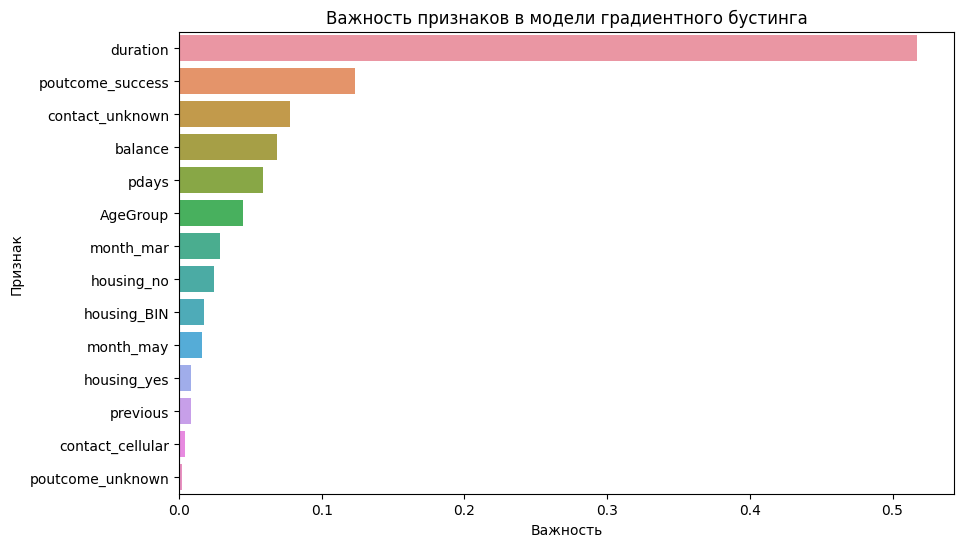

In [58]:

# Создание графика важности признаков
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance_df, x='Важность', y='Признак')
plt.title('Важность признаков в модели градиентного бустинга')
plt.xlabel('Важность')
plt.ylabel('Признак')
plt.show()


Данные  3 признака могут иметь наибольшую важность по следующим причинам:

duration: Продолжительность разговора является важным признаком, потому что она может сильно влиять на решение клиента о принятии предложения или совершении целевого действия. Более длительные разговоры могут свидетельствовать о более глубоком вовлечении клиента и большей вероятности успеха в маркетинговой кампании.

poutcome_success: Признак "poutcome_success" указывает на успешные предыдущие маркетинговые кампании. Если клиент имел успешный опыт с предыдущей кампанией, это может положительно влиять на его отношение к текущей кампании и повышать вероятность успеха.

contact_unknown: Признак "contact_unknown" указывает на неизвестный тип контакта с клиентом. Это может означать, что клиент был недоступен или не указал предпочитаемый способ связи. Такие клиенты могут быть более сложными для достижения и требовать дополнительных усилий в рамках маркетинговой кампании.

### Задания 6,7,8

In [59]:
# реализовываем оптимизацию гиперпараметров с помощью Optuna

def optuna_rf(trial):
  # задаем пространства поиска гиперпараметров
  n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
  max_depth = trial.suggest_int('max_depth', 10, 30, 1)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)
  # создаем модель
  opt_model = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          random_state=42)
  # обучаем модель
  opt_model.fit(X_train_scaled, y_train)
  score = metrics.f1_score(y_train, opt_model.predict(X_train_scaled))

  return score
  # Поиск оптимальных гиперпараметров
sampler = optuna.samplers.TPESampler(seed=42)
study = optuna.create_study(
    sampler=sampler, study_name='RandomForestClassifier', direction='maximize')
study.optimize(optuna_rf, n_trials=20)
print(f'Лучшие параметры:\n{study.best_params}')


[I 2023-07-12 20:13:22,665] A new study created in memory with name: RandomForestClassifier


[I 2023-07-12 20:13:23,523] Trial 0 finished with value: 0.8478396994364433 and parameters: {'n_estimators': 137, 'max_depth': 29, 'min_samples_leaf': 8}. Best is trial 0 with value: 0.8478396994364433.
[I 2023-07-12 20:13:24,584] Trial 1 finished with value: 0.8680370312254825 and parameters: {'n_estimators': 160, 'max_depth': 13, 'min_samples_leaf': 3}. Best is trial 1 with value: 0.8680370312254825.
[I 2023-07-12 20:13:25,209] Trial 2 finished with value: 0.8490566037735848 and parameters: {'n_estimators': 105, 'max_depth': 28, 'min_samples_leaf': 7}. Best is trial 1 with value: 0.8680370312254825.
[I 2023-07-12 20:13:26,174] Trial 3 finished with value: 0.8350157728706625 and parameters: {'n_estimators': 171, 'max_depth': 10, 'min_samples_leaf': 10}. Best is trial 1 with value: 0.8680370312254825.
[I 2023-07-12 20:13:27,496] Trial 4 finished with value: 0.8704663212435233 and parameters: {'n_estimators': 184, 'max_depth': 14, 'min_samples_leaf': 3}. Best is trial 4 with value: 0.87

Лучшие параметры:
{'n_estimators': 151, 'max_depth': 22, 'min_samples_leaf': 2}


In [60]:
# Модель с лучшими параметрами  
rf_best = ensemble.RandomForestClassifier(
    **study.best_params, random_state=42)
rf_best.fit(X_train_scaled, y_train)
y_test_pred = rf_best.predict(X_test_scaled)
print('Тестовая выборка:\n',metrics.classification_report(y_test, y_test_pred))

Тестовая выборка:
               precision    recall  f1-score   support

           0       0.84      0.80      0.82      1790
           1       0.78      0.83      0.81      1545

    accuracy                           0.81      3335
   macro avg       0.81      0.82      0.81      3335
weighted avg       0.82      0.81      0.81      3335



### Проведенный анализ различных моделей классификации позволяет сделать следующий краткий вывод:

1) Логистическая регрессия показала хорошие результаты, но немного уступает другим моделям в точности предсказания.

2) Решающие деревья и случайный лес демонстрируют хорошую обобщающую способность и стабильность показателей на тестовой выборке.

3) Градиентный бустинг показал отличные результаты, обладая высокой точностью и F1-мерой как на тренировочной, так и на тестовой выборке.

4) Стекинг моделей позволяет объединить преимущества различных моделей и достичь хорошего качества классификации.

5) Модель с оптимизацией гиперпараметров с помощью Optuna показала приемлемое качество, но несколько уступает другим моделям.

В целом, все модели демонстрируют неплохое качество классификации. Наиболее успешными оказались модели градиентного бустинга и стекинг, которые показали наилучшие показатели F1-меры.